In [ ]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform


# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler

# my biling project, replace with yours
PROJECT = "questrom"

In [ ]:
# connect to Big Query if on Colab

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# get the datasets
SQL = """select * from `questrom.datasets.hockey-skaters`"""
players_raw = pd.read_gbq(SQL, PROJECT)

SQL = """select * from `questrom.datasets.hockey-teams`"""
teams_raw = pd.read_gbq(SQL, PROJECT)

In [ ]:
# profile
print(players_raw.shape)
print(teams_raw.shape)

(995, 26)
(31, 15)


In [ ]:
# what are the columns
print(players_raw.columns)
print(teams_raw.columns)

Index(['Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', 'plus_minus',
       'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV_assists', 'PP_assists',
       'SH_assists', 'S', 'S_pct', 'TOI', 'BLK', 'HIT', 'FOW', 'FOL',
       'FO_pct'],
      dtype='object')
Index(['Team', 'Abbrev', 'Division', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS_pct',
       'GF', 'GA', 'SRS', 'SOS', 'RPt_pct', 'ROW'],
      dtype='object')


In [ ]:
# I tend to prefer lowercase cols
players_raw.columns = players_raw.columns.str.lower()
teams_raw.columns = teams_raw.columns.str.lower()

In [ ]:
# step 1 = filter players
ROWS = np.where((players_raw.gp >=10) & (players_raw.toi >=100))
players = players_raw.iloc[ROWS[0], :]

## Exercise 1


In [ ]:
# what do we have
players.head(3)

player  age   tm pos  gp  g  ...  toi  blk  hit  fow  fol  fo_pct
6   Anthony Bitetto   28  MIN   D  18  0  ...  237   13   40    0    0     NaN
32      Justin Falk   30  OTT   D  10  0  ...  129    9   36    0    0     NaN
34   Trent Frederic   20  BOS   C  15  0  ...  141    3   18   41   40    50.6

[3 rows x 26 columns]

In [ ]:
# explore
players.describe().T

count        mean         std    min    25%    50%      75%     max
age         827.0   26.327690    4.034085   18.0   23.0   26.0    29.00    42.0
gp          827.0   54.447400   24.104204   10.0   32.0   61.0    78.00    82.0
g           827.0    9.111245    9.647025    0.0    2.0    6.0    13.00    51.0
a           827.0   15.318017   14.264509    0.0    4.0   11.0    22.00    87.0
pts         827.0   24.429262   22.450015    0.0    7.0   18.0    35.00   128.0
plus_minus  827.0   -0.385732   10.639933  -41.0   -7.0   -1.0     5.00    39.0
pim         827.0   24.295042   20.721140    0.0    8.0   20.0    34.00   153.0
ps          827.0    2.798670    2.825774   -1.1    0.6    2.0     4.30    14.6
ev          827.0    7.065296    7.062885    0.0    2.0    5.0    11.00    37.0
pp          827.0    1.764208    3.084567    0.0    0.0    0.0     2.00    20.0
sh          827.0    0.281741    0.702257    0.0    0.0    0.0     0.00     6.0
gw          827.0    1.428053    1.795363    0.0    0.0    1.0     2.00    10.0
ev_assists  827.0   11.661427    9.634055    0.0    4.0   10.0    17.00    54.0
pp_assists  827.0    3.360339    5.475083    0.0    0.0    1.0     5.00    33.0
sh_assists  827.0    0.296252    0.689262    0.0    0.0    0.0     0.00     4.0
s           827.0   95.807739   68.275156    5.0   37.5   84.0   135.00   365.0
s_pct       827.0    8.244256    5.240522    0.0    4.7    7.8    11.50    28.6
toi         827.0  903.159613  517.824677  103.0  408.5  921.0  1318.00  2189.0
blk         827.0   43.394196   38.671452    0.0   17.0   31.0    56.00   208.0
hit         827.0   67.602177   53.090586    0.0   28.0   54.0    92.00   305.0
fow         827.0   90.223700  187.292173    0.0    0.0    4.0    69.00  1086.0
fol         827.0   90.151149  173.796269    0.0    0.0    7.0    75.00   935.0
fo_pct      571.0   42.394746   20.007036    0.0   34.2   45.1    51.45   100.0

In [ ]:
## missing data, for the most part, is not a problem short of one column

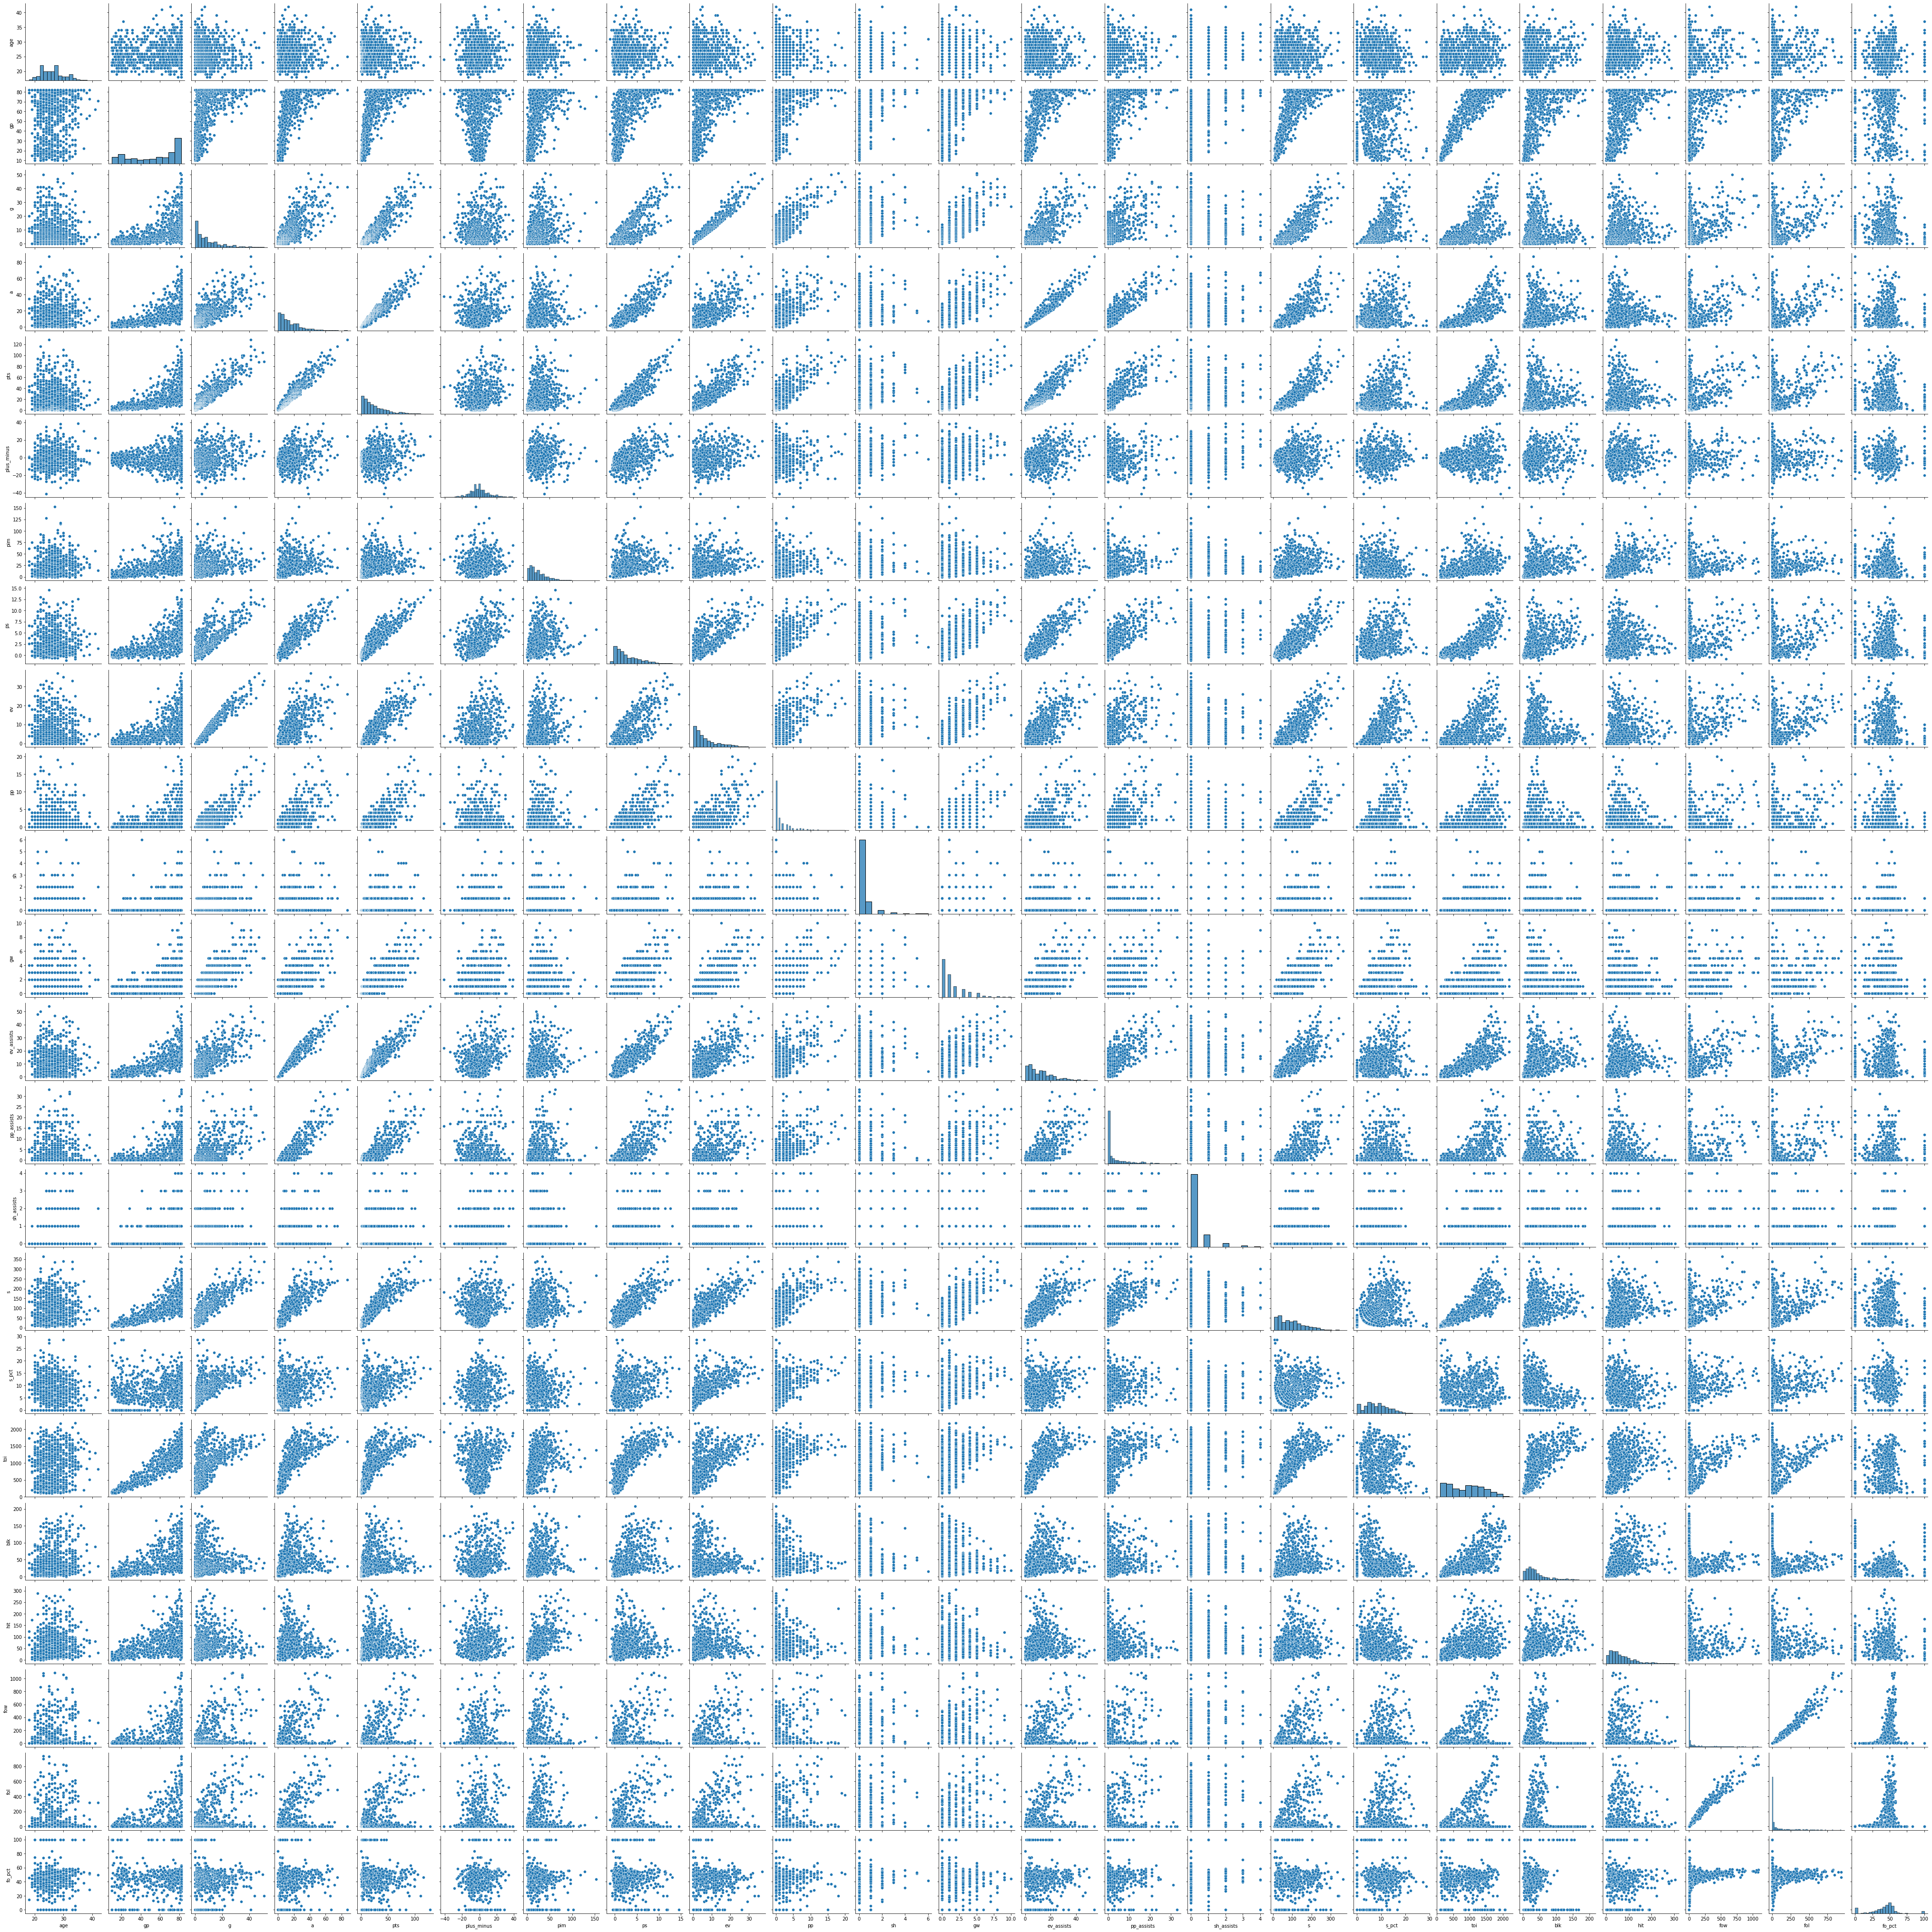

In [ ]:
##  pairs plot 
## this might take a few moments!
sns.pairplot(players)

> Hard to read, but should be in the column order AND gives us a high level sense of relationships or distros.

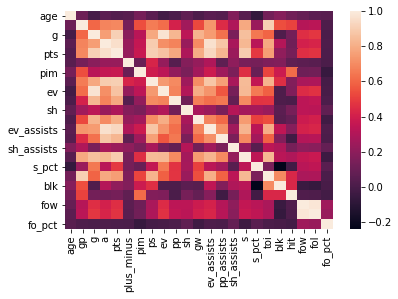

In [ ]:
# we can obviously get correlations easily
player_corr = players.corr()
sns.heatmap(player_corr)

# Exercise 2

In [ ]:
# replace missing value with zero
# this is because the players never took a face off
players.fo_pct.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# confirm that we are all set
players.isna().sum().sum()

0

In [ ]:
# adust a few of the stats to rate stats (per games played)
# I will drop the original vars
players['goals_game'] = players.g / players.gp
players['assists_game'] = players.a / players.gp
players['pts_game'] = players.pts / players.gp

players.drop(columns=['g', 'a', 'pts'], inplace=True)

In [ ]:
players.head(3)

player  age   tm pos  ...  fo_pct  goals_game  assists_game  pts_game
6   Anthony Bitetto   28  MIN   D  ...     0.0         0.0           0.0       0.0
32      Justin Falk   30  OTT   D  ...     0.0         0.0           0.0       0.0
34   Trent Frederic   20  BOS   C  ...    50.6         0.0           0.0       0.0

[3 rows x 26 columns]

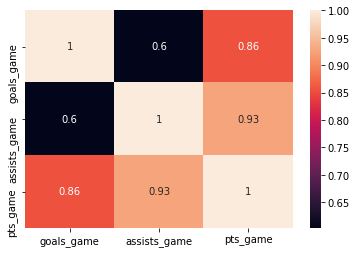

In [ ]:
# curious, what is the correlation of these 3 new vars
sns.heatmap(players.iloc[:, -3:].corr(), annot=True)

In [ ]:
# with the features all set and no missing data
# construct a datset of stats (numeric data) and attributes (categorical)
player_stats = players.copy()

COLS = ['player','age','tm', 'pos', 'gp', 'ps']

player_atts = player_stats.loc[:, COLS]
player_stats = player_stats.drop(columns=COLS)


In [ ]:
# confirm
player_stats.head(3)

plus_minus  pim  ev  pp  ...  fo_pct  goals_game  assists_game  pts_game
6           -8    4   0   0  ...     0.0         0.0           0.0       0.0
32          -4   11   0   0  ...     0.0         0.0           0.0       0.0
34          -4   15   0   0  ...    50.6         0.0           0.0       0.0

[3 rows x 20 columns]

In [ ]:
# confirm
player_atts.head(3)

player  age   tm pos  gp   ps
6   Anthony Bitetto   28  MIN   D  18 -0.2
32      Justin Falk   30  OTT   D  10 -0.2
34   Trent Frederic   20  BOS   C  15 -0.4

> Note: that as long as we don't sort the data, we can align the rows later for concatenation to rebuild a dataset!

# Exercise 3

In [ ]:
# first, I am going to scale the data given the varying units of measurement
sc = StandardScaler()
ps = sc.fit_transform(player_stats)

ps = pd.DataFrame(ps, columns=player_stats.columns)

In [ ]:
# confirm we are looking good
ps.head(3)

plus_minus       pim        ev  ...  goals_game  assists_game  pts_game
0   -0.716064 -0.980029 -1.000947  ...   -1.176666     -1.439085 -1.479648
1   -0.339895 -0.642006 -1.000947  ...   -1.176666     -1.439085 -1.479648
2   -0.339895 -0.448849 -1.000947  ...   -1.176666     -1.439085 -1.479648

[3 rows x 20 columns]

In [ ]:
# going to do euclidean and cosine distance
diste = pdist(ps.values)
distc = pdist(ps.values, metric="cosine")

In [ ]:
# I am going to start with complete linkage
# remember: when we pass in a 1d distance matrix, the metric arg is not applicable
# b/c we already did it 

# put both on the same linkage for now, but you could always generate multiple plots!
hclust_e = linkage(diste)
hclust_c = linkage(distc)

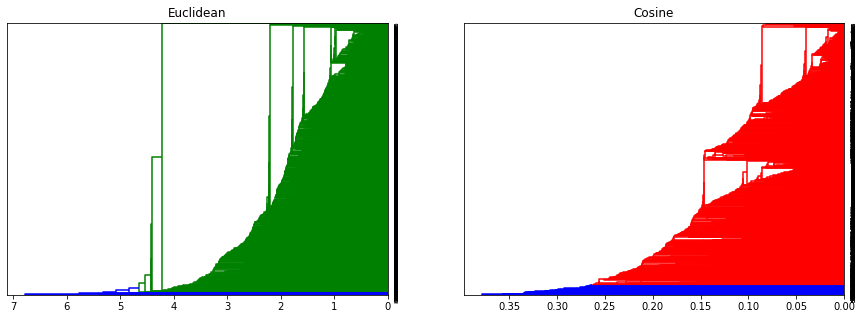

In [ ]:
# both plots
LINKS = [hclust_e, hclust_c]
TITLE = ['Euclidean', 'Cosine']

plt.figure(figsize=(15, 5))

# loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1, 2, i+1)
  plt.title(TITLE[i])
  dendrogram(m,
            #  labels = ps.index,
             leaf_rotation=90,
            #  leaf_font_size=10,
             orientation="left")
  
plt.show()

> The plots are hard to read, but we can get a sense of the shape of how the clustering is taking place.  Euclidean is incremental, with larger groups joining late.  Both identified outliers, though cosine appears to suggest more with smaller groups uniting earlier in the algorithm.  I will go with cosine.

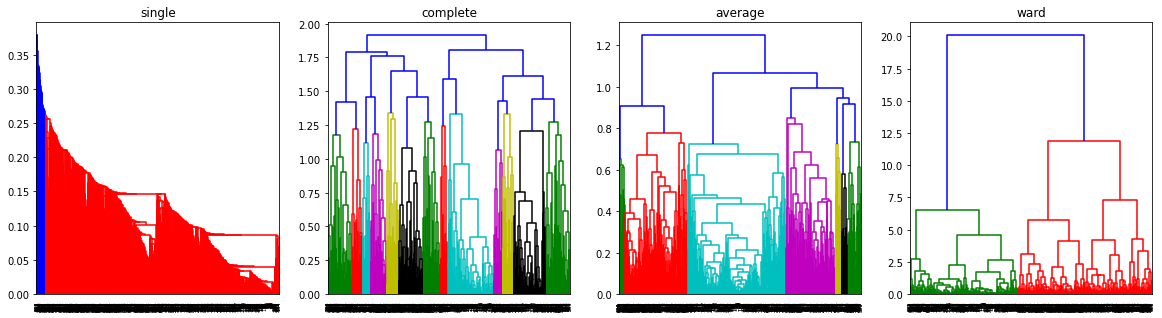

In [ ]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m), 
             leaf_rotation=90)
  
plt.show()


> For this business problem, I actually like the segmentation and the "lanes" that are created as part of the complete linkage. So, I will use cosine + complete linkage to form the clusters.  Because there are a number of clusters, I am going to stay with 7, as not not overly condense the segmentation lanes that we see in the plot.

In [ ]:
# the labels 
labs = fcluster(linkage(distc, method="complete"), 7, criterion="maxclust")

# confirm
np.unique(labs)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# lets put this back onto the players dataset
players['cluster'] = labs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# a quick review
players.head(3)

player  age   tm pos  ...  goals_game  assists_game  pts_game  cluster
6   Anthony Bitetto   28  MIN   D  ...         0.0           0.0       0.0        5
32      Justin Falk   30  OTT   D  ...         0.0           0.0       0.0        5
34   Trent Frederic   20  BOS   C  ...         0.0           0.0       0.0        7

[3 rows x 27 columns]

In [ ]:
# how many players per cluster assignment?
players.cluster.value_counts(dropna=False, sort=False)

1    120
2     82
3     41
4    143
5    181
6     68
7    192
Name: cluster, dtype: int64

> All in all, and as expected per the plot, we see that the clusters are decently balanced.  Its unreleasitc to think we will always have equal numbers across the columns, but ideally we avoid clusters that are really large or small.

> THOUGHT EXERCISE:  What does it possibly say about a dataset when the cluster solutions have segments that are very large or very small relative to the number of records in the full dataset?

# Exercise 4

In [ ]:
# lets profile the cluster solutions
player_numeric = players.select_dtypes('number')

clus_profile = player_numeric.groupby("cluster").mean()

clus_profile.T

cluster                 1            2  ...           6           7
age             27.400000    27.121951  ...   26.867647   25.072917
gp              73.666667    72.512195  ...   58.191176   34.484375
plus_minus       3.575000    -0.792683  ...   -2.500000   -3.192708
pim             38.858333    27.975610  ...   30.632353   10.213542
ps               4.863333     3.436585  ...    1.082353    0.614062
ev               4.650000    12.085366  ...    5.529412    3.510417
pp               1.075000     2.512195  ...    0.338235    0.614583
sh               0.191667     0.768293  ...    0.750000    0.020833
gw               1.083333     2.378049  ...    0.911765    0.562500
ev_assists      15.766667    17.585366  ...    7.882353    4.463542
pp_assists       3.841667     4.792683  ...    0.220588    0.729167
sh_assists       0.591667     0.585366  ...    0.500000    0.026042
s              120.925000   132.731707  ...   73.705882   45.614583
s_pct            4.681667    11.241463  ...    9.505882    8.970312
toi           1524.116667  1199.134146  ...  753.647059  415.395833
blk            115.500000    42.439024  ...   33.764706   15.119792
hit            110.966667    72.829268  ...  121.176471   35.713542
fow              0.150000   498.792683  ...   63.485294   43.338542
fol              0.266667   463.109756  ...   65.514706   49.119792
fo_pct          10.635833    51.145122  ...   38.997059   43.231250
goals_game       0.080265     0.208711  ...    0.115909    0.120070
assists_game     0.273862     0.314971  ...    0.142909    0.150255
pts_game         0.354128     0.523682  ...    0.258818    0.270326

[23 rows x 7 columns]

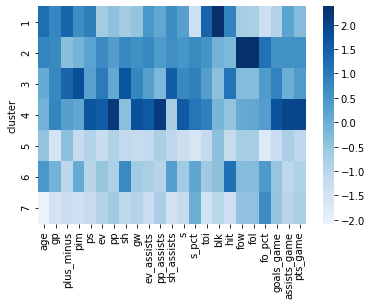

In [ ]:
# we can also plot this as a heatmap, but we should normalize the data
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=clus_profile.index, 
                              columns=clus_profile.columns)

sns.heatmap(cluster_scaled, cmap="Blues", center=0)

Some example findings from the profiling.  Recall that we only used select variables and that they were scaled!

- It's easy to see that some clusters have higher averages in various metrics than others
- Sometimes a cluster is average, while others tend to overperform/underpeform overall
- I won't go into specifics relative to the game of hockey, but it's not surprising that "leadership" type skills (e.g. faceoff information) stands out.
- Not all of the states were game adjusted (rate stats).  That could be an area of improvement for this exercise.
- If this were a truly robust deliverable, we would want to think about giving each cluster a persona, or one that describes the "typical" player in the assignment.  

> This is a common task for marketing segmentation where we want to characterize each segment via a story that can be used for positioning, etc.



# Exercise 5

Now that we have the assignments, and each player has a team, we can look at how teams are constructed.

In [ ]:
# group by team and pivot on cluster, count
team_cluster = pd.crosstab(players.tm, players.cluster)

In [ ]:
# this defaults to count, but we normalized the data 

team_cluster = pd.crosstab(players.tm, players.cluster, normalize=0)

In [ ]:
team_cluster.head(3)

cluster         1         2         3         4         5         6         7
tm                                                                           
ANA      0.088235  0.088235  0.058824  0.029412  0.264706  0.058824  0.411765
ARI      0.153846  0.076923  0.038462  0.115385  0.192308  0.153846  0.269231
BOS      0.133333  0.033333  0.000000  0.200000  0.200000  0.133333  0.300000

In [ ]:
# confirm that each team's row sums to 100
team_cluster.sum(axis=1).head(3)

tm
ANA    1.0
ARI    1.0
BOS    1.0
dtype: float64

In [ ]:
teams_raw.head(3)

team abbrev  division  gp   w  ...   ga   srs   sos  rpt_pct  row
0  Tampa Bay Lightning*    TBL  Atlantic  82  62  ...  222  1.21 -0.05    0.726   56
1        Boston Bruins*    BOS  Atlantic  82  49  ...  215  0.52 -0.01    0.604   47
2  Toronto Maple Leafs*    TOR  Atlantic  82  46  ...  251  0.42 -0.01    0.573   46

[3 rows x 15 columns]

In [ ]:
# ok, now that we have the teams by cluster profiles, we can
# add on a metric for success, points

team_pts = teams_raw.loc[:, ["abbrev", "pts"]]

team_pts.head(3)

abbrev  pts
0    TBL  128
1    BOS  107
2    TOR  100

In [ ]:
# now lets get the cluster profile aligned
team_cluster2 = team_cluster.reset_index(drop=False, inplace=False)
team_cluster2.rename(columns={'tm':'abbrev'}, inplace=True)
team_cluster2.head(3)

cluster abbrev         1         2  ...         5         6         7
0          ANA  0.088235  0.088235  ...  0.264706  0.058824  0.411765
1          ARI  0.153846  0.076923  ...  0.192308  0.153846  0.269231
2          BOS  0.133333  0.033333  ...  0.200000  0.133333  0.300000

[3 rows x 8 columns]

In [ ]:
# finally append the data
team_profile = pd.merge(team_pts, team_cluster2, how="inner")
team_profile.head(3)

abbrev  pts         1         2  ...         4         5         6         7
0    TBL  128  0.238095  0.095238  ...  0.285714  0.142857  0.142857  0.000000
1    BOS  107  0.133333  0.033333  ...  0.200000  0.200000  0.133333  0.300000
2    TOR  100  0.083333  0.041667  ...  0.250000  0.291667  0.000000  0.208333

[3 rows x 9 columns]

In [ ]:
# lets create a compounded key
team_profile['tm_pts'] = team_profile.abbrev + "-" + team_profile.pts.astype('str')

team_profile.head(3)

abbrev  pts         1         2  ...         5         6         7   tm_pts
0    TBL  128  0.238095  0.095238  ...  0.142857  0.142857  0.000000  TBL-128
1    BOS  107  0.133333  0.033333  ...  0.200000  0.133333  0.300000  BOS-107
2    TOR  100  0.083333  0.041667  ...  0.291667  0.000000  0.208333  TOR-100

[3 rows x 10 columns]

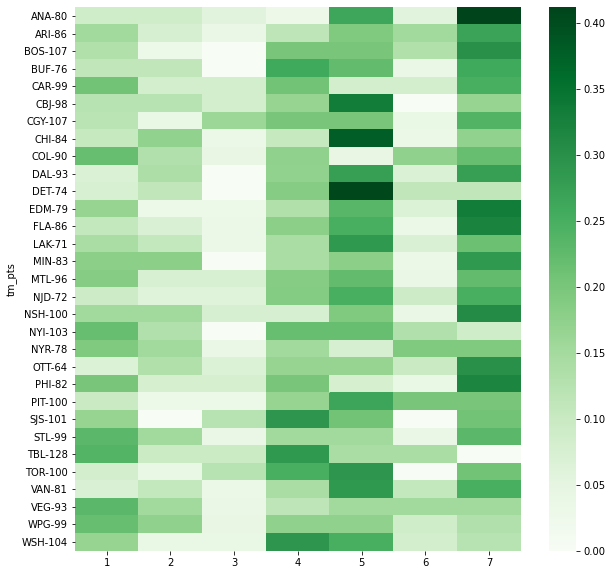

In [ ]:
# heatmap the constuction
# hack

plt.figure(figsize=(10, 10))

tmp = team_profile.drop(columns=["abbrev", "pts"])


sns.heatmap(tmp.groupby("tm_pts").mean(), cmap="Greens")


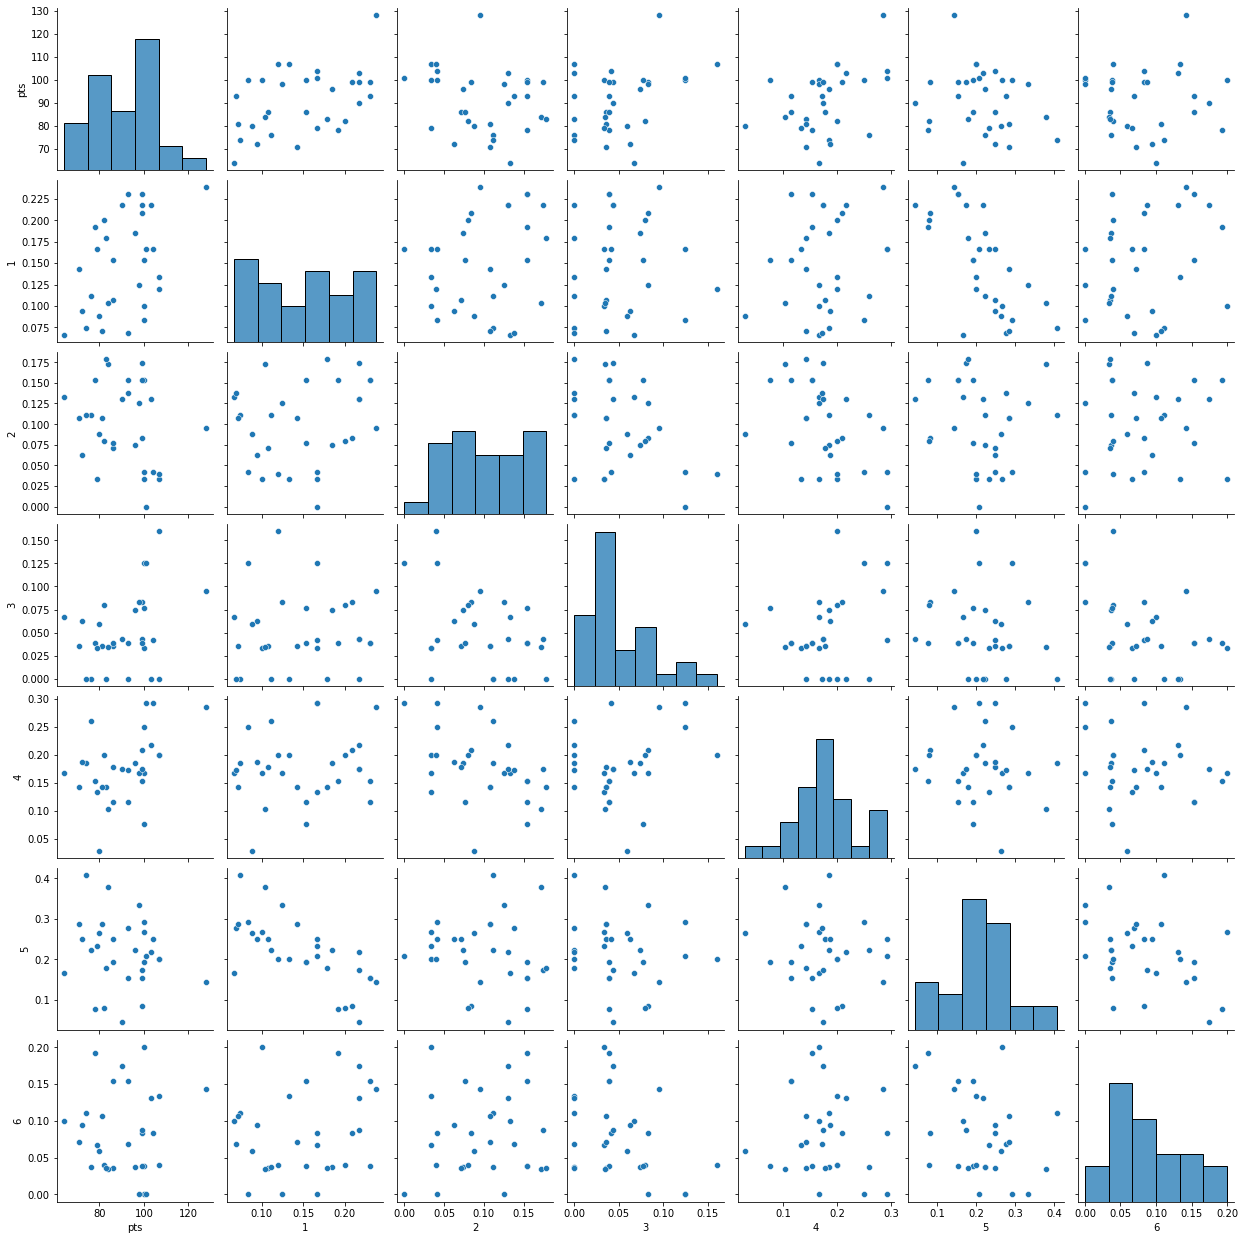

In [ ]:
# we can also look at points and cluster distributions for visual patterns of
# what how successful teams were constructed, perhaps there are patterns
sns.pairplot(team_profile.iloc[:, 1:8])

A few notes:

1. STL was the champion in this year, and they were relatively balanced given other teams

2.  BOS lost to STL in the Championship, but they were constructed from clusters 4-7.  Perhaps they should 

3.  From the pairsplot, visually loose relationship between clusters 1 and 4 and the number of points a team had.  Could explain why the Bruins had success, but ultimately lost.  They needed more of cluster 1, which STL had.

# Summary

I added a good amount of depth to what is possible, and I do not expect that you followed each step the way that I did. However, I wanted to highlight a few things:

- Short of a few summaries, we were able to find structure segments within our data set even if you weren’t aware of how the columns are related. This starts to highlight the power of unsupervised machine learning!

- There is no right answer! Analytics and Data Science is an iterative approach. We often have to try different combinations of methods (distance calculations, linkage types etc.) to find a solution that may match what our business challenge is.

- Really understanding the data set and the domain absolutely makes our lives as analysts and data scientists easier. There typically is positive return on our time when we explore and learn more about the domain prior to analyzing data. Consider this for your Capstone Projects!